# Table of Contents
1. [Introduction](##introduction)
2. [Model Overview](##model-overview)
3. [Feature Selection](##feature-selection)
4. [Expected Goals](##expected-goals)
5. [Season Simulation](##season-simulation)
6. [Conclusion](##conclusion)

## Introduction <a name="introduction"></a>
The Premier League is the most-watched professional soccer league on the planet. << STATS >>. 

## Model Overview <a name="model-overview"></a>
In the hopes of predicting the outcome of individual games, we considered data from the Premier League's official website on game-level statistics and aggregated financial information regarding teams transfer business. 

### Multi-class Model
Firstly, we consider a simple multi-class model where for each game there were 3 potential outcomes ($y$) where

$$
y = \cases{-1 \,if\,away\,team\,wins\\ 
            0 \,draw\\
            1 \,if\,home\,team\,wins}
$$

This is a transformed variable that we will calculate using a `score_to_win()` function provided in our `helper` suite. 

#### Prepare Data

In [1]:
import pandas as pd
from helpers import *
%matplotlib inline

In [2]:
DATA_SRC = '../Data/PL_site_2006_2018/masterdata.csv'
df = pd.read_csv(DATA_SRC)

# create win/lose label
df['target'] = df[['Score_home', 'Score_away']].apply(score_to_win, axis = 1)
df.sort_values('MatchID', inplace = True)
df.head()

,MatchID,Home_team,Away_team,Score_home,Score_away,Possession_home,Possession_away,Shots_on_target_home,Shots_on_target_away,Shots_home,...,year,Expenditures_home,Arrivals_home,Income_home,Departures_home,Expenditures_away,Arrivals_away,Income_away,Departures_away,target
373,5567,Arsenal,Aston Villa,1,1,72.9,27.1,7,3,24,...,2007,17.10,18,14.85,21,28.16,17,2.08,18,0
379,5568,Bolton,Spurs,2,0,37.8,62.2,4,2,13,...,2007,19.38,16,4.39,16,69.54,23,44.06,23,1
374,5569,Everton,Watford,2,1,47.0,53.0,2,7,8,...,2007,20.41,11,2.85,16,11.97,29,15.39,23,1
375,5570,Newcastle,Wigan,2,1,55.3,44.7,5,4,8,...,2007,36.34,8,12.74,14,29.24,23,27.73,25,1
376,5571,Portsmouth,Blackburn,3,0,44.3,55.7,11,3,21,...,2007,10.37,28,1.43,32,18.84,21,19.28,25,1


In order to fit our model appropriately, we have to consider an $X$ matrix of values that has no information regarding our target variables. So, here we will drop the features that might provide the model information on $y$, i.e. `MatchID`, `Home_team`, `Away_team`, `Score_home`, `Score_away`, and `year` along with our `target`. 

In [3]:
FEATURES_TO_DROP = ['target', 'MatchID', 'Home_team', 'Away_team', 'Score_home', 'Score_away', 'year']
df_wo = df.drop(columns = FEATURES_TO_DROP)

### EDA
Prior to setting up any model it's important to visualize the features of our data so that we can get a sense of what might work. Firstly, we'll visualize the pair-wise correlation of variables. Given that the game-stats are symmetric (each home & away team has a value) we'll just investigate the home-team features.

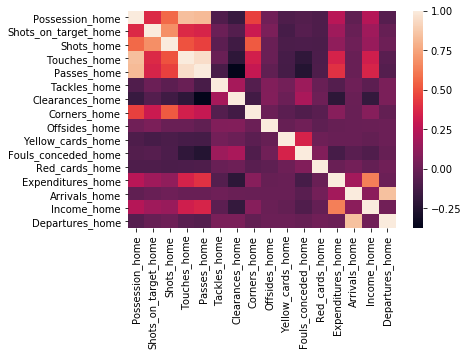

In [4]:
import seaborn as sns
home_features = [ f for f in list(df_wo) if '_home' in f ]
corr = df_wo[home_features].corr()
_ = sns.heatmap(corr)

<< COMMENT >>

Now, let's investigate their various distributions.

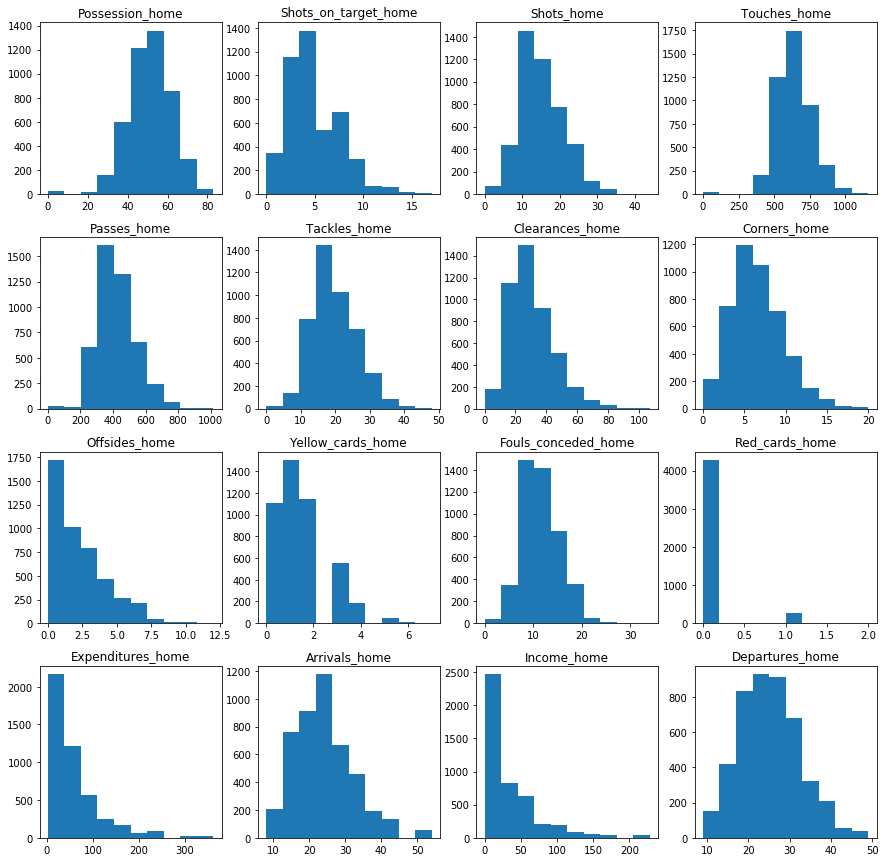

In [5]:
import matplotlib.pyplot as plt
n_figs = len(home_features)
columns = 4

fig, axes = plt.subplots(int(n_figs/columns), columns, figsize = (15, 15))
plt.subplots_adjust(hspace = .25)

for i, feature in enumerate(home_features):
    row = int(i / columns)
    column = i % columns
    axes[row, column].hist(df[feature].values)
    axes[row, column].set_title(feature)

What about the distribution of our target variable?

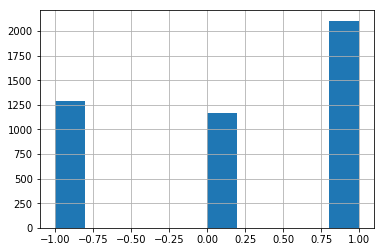

In [6]:
_ = df.target.hist()

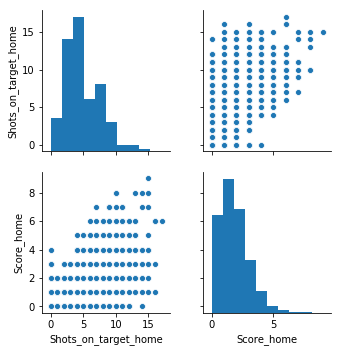

In [7]:
_ = sns.pairplot(df[['Shots_on_target_home', 'Score_home']])

## <a name = "feature-selection"></a> Feature Selection 
<< EXPLANATION >>

### Feature Engineering
#### Form

In [8]:
scores = df[['MatchID', 'Home_team', 'Away_team', 'Score_home', 'Score_away']].values
gd = gd_vectors(scores)

away_form_exp, home_form_exp = [], []
for game in scores:
    id, home_team, away_team, _, _ = game
    away_form_exp.append( exponential_momentum(id, away_team, gd, alpha = .65) )
    home_form_exp.append( exponential_momentum(id, home_team, gd, alpha = .65) )

df_form = df.copy()
df_form['Form_away'] = pd.Series(away_form_exp)
df_form['Form_home'] = pd.Series(home_form_exp)

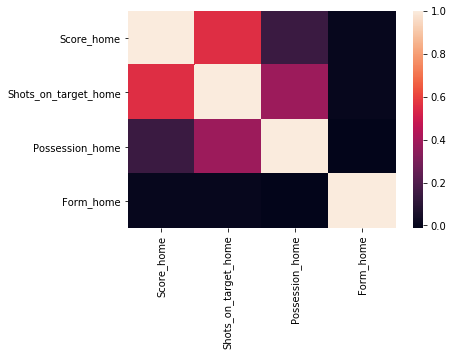

In [9]:
corr = df_form[['Score_home', 'Shots_on_target_home','Possession_home','Form_home']].corr()
_ = sns.heatmap(corr)

<< ADD ANOVA & BACKWARD SELECTION RESULTS >>

### Testing of Full Model
Now, just for completeness and given we have a smaller dataset, we should fit a suite of full models and from there we can investigate potential performance gains. From the beginning we'll start with some general model and perform cross-validation & other steps later.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [25]:
clfs = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier(),
        KNeighborsClassifier(), GaussianNB(), MLPClassifier(), SVC()]

# first run without form feature
X = df_wo.values
y = df['target'].values

run_model_diagnostics(X, y, clfs)

/home/thomas/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/thomas/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/thomas/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/thomas/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarn

{'LogisticRegression': [('score', 0.6513157894736842)],
 'RandomForestClassifier': [('score', 0.5942982456140351)],
 'GradientBoostingClassifier': [('score', 0.6348684210526315)],
 'KNeighborsClassifier': [('score', 0.47478070175438597)],
 'GaussianNB': [('score', 0.555921052631579)],
 'MLPClassifier': [('score', 0.6348684210526315)],
 'SVC': [('score', 0.4649122807017544)]}

In [26]:
# now we'll repeat with the form variable included

<< INVESTIGATION OF COEFFICIENTS >>
### Feature Set Reduction

## Expected Goals
The real idea, here, though is to generate a model that predicts the number of goals scored by each team within a single game. From there, of course, we can make predictions about who will win. I.e. now the function of interest becomes:

$$
team\,features\mapsto goals
$$

We can consider both transfer market spending along with the game-level statistics discussed above as team features. These should (if our logic is sound) form a generating function for goals within a game. With such a function, we can make predictions and, even, simulations over a period of time.

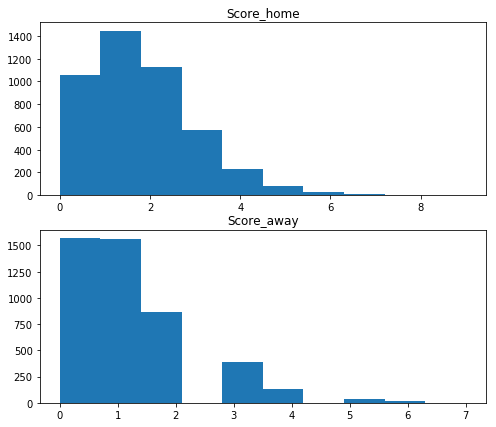

In [34]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8,7))

ax1.hist(df.Score_home)
ax1.set_title("Score_home")
ax2.hist(df.Score_away)
_ = ax2.set_title("Score_away")

Neither of these look like a normal distribution. If anything, and this makes intuitive sense, they appear to be following an exponential or Poisson distribution. Both are used in various applications to predict waiting times of random, independent events. In a sense, a goal in a game is a pseudo-random event. If you've ever watched their occurence does not rely on the entire game but rather a very short passage of play. How can we use this knowledge to make predictions?
### Data Preparation

Now, in order to perform this analysis we'll need to melt out each individual game above such that each individual row consists of one team's result (i.e. there will be two rows per game).

In [50]:
FEATURES_TO_DROP = ['Shots_home', 'Shots_away', 'Touches_home', 
                                 'Touches_away', 'Possession_home', 'Possession_away',
                                 'Tackles_home', 'Tackles_away', 'Arrivals_home', 'Arrivals_away',
                                 'Departures_home', 'Departures_away', 'Corners_home', 'Corners_away',
                                 'Red_cards_home', 'Red_cards_away', 'Yellow_cards_home', 'Yellow_cards_away']
TARGET_PROXIES = ['MatchID', 'Team', 'year', 'Score']

In [45]:
df_c = df.drop(columns = FEATURES_TO_DROP)
print(list(df_c))

['MatchID', 'Home_team', 'Away_team', 'Score_home', 'Score_away', 'Shots_on_target_home', 'Shots_on_target_away', 'Passes_home', 'Passes_away', 'Clearances_home', 'Clearances_away', 'Offsides_home', 'Offsides_away', 'Fouls_conceded_home', 'Fouls_conceded_away', 'year', 'Expenditures_home', 'Income_home', 'Expenditures_away', 'Income_away', 'target']


In [46]:
home_attributes = ['MatchID', 'Home_team', 'year'] + [a for a in list(df_c) if 'home' in a]
away_attributes = ['MatchID', 'Away_team', 'year'] + [a for a in list(df_c) if 'away' in a]

print(home_attributes, '\n')
print(away_attributes)

['MatchID', 'Home_team', 'year', 'Score_home', 'Shots_on_target_home', 'Passes_home', 'Clearances_home', 'Offsides_home', 'Fouls_conceded_home', 'Expenditures_home', 'Income_home'] 

['MatchID', 'Away_team', 'year', 'Score_away', 'Shots_on_target_away', 'Passes_away', 'Clearances_away', 'Offsides_away', 'Fouls_conceded_away', 'Expenditures_away', 'Income_away']


In [47]:
melted = []

for _, row in df_c.iterrows():
    home_team = [row[attr] for attr in away_attributes] + [1]
    away_team = [row[attr] for attr in home_attributes] + [0]
    melted.append(home_team)
    melted.append(away_team)

print(melted[0])

[5567, 'Aston Villa', 2007, 1, 3, 232, 51, 6, 19, 28.16, 2.08, 1]


In [48]:
features = ['MatchID', 'Team', 'year'] + [a.split('_')[0] for a in list(df_c) if 'home' in a] + ['IsHome']
print(features)

['MatchID', 'Team', 'year', 'Score', 'Shots', 'Passes', 'Clearances', 'Offsides', 'Fouls', 'Expenditures', 'Income', 'IsHome']


In [49]:
melted_df = pd.DataFrame(melted, columns = features)
melted_df.head()

,MatchID,Team,year,Score,Shots,Passes,Clearances,Offsides,Fouls,Expenditures,Income,IsHome
0,5567,Aston Villa,2007,1,3,232,51,6,19,28.16,2.08,1
1,5567,Arsenal,2007,1,7,631,14,2,10,17.10,14.85,0
2,5568,Spurs,2007,0,2,427,43,1,22,69.54,44.06,1
3,5568,Bolton,2007,2,4,243,20,3,22,19.38,4.39,0
4,5569,Watford,2007,1,7,321,32,1,15,11.97,15.39,1


In [63]:
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, LassoLars, Ridge, BayesianRidge, SGDRegressor, LinearRegression
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor

In [64]:
regressors = [SVR(), MLPRegressor(), KNeighborsRegressor(), Lasso(), LassoLars(), Ridge(), BayesianRidge(),
              SGDRegressor(), AdaBoostRegressor(), ExtraTreesRegressor(), GradientBoostingRegressor(),
              RandomForestRegressor(), LinearRegression()]

In [57]:
melted_df_wo = melted_df.drop(columns = TARGET_PROXIES)

X = melted_df_wo.values
y = melted_df['Score'].values

run_model_diagnostics(X, y, regressors, is_classification = False)

/home/thomas/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/thomas/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/thomas/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/thomas/.local/lib/python3.6/site-packages/sklearn/ensem

{'SVR': [('score', -0.01571468849561386)],
 'MLPRegressor': [('score', 0.33881569927024935)],
 'KNeighborsRegressor': [('score', -0.027131499263123082)],
 'Lasso': [('score', 0.2168256347262381)],
 'LassoLars': [('score', -0.0001729217095645108)],
 'Ridge': [('score', 0.35040100218606834)],
 'BayesianRidge': [('score', 0.35027316022330307)],
 'SGDRegressor': [('score', -3.005482263250359e+27)],
 'AdaBoostRegressor': [('score', 0.29499890696028197)],
 'ExtraTreesRegressor': [('score', 0.2605098757626714)],
 'GradientBoostingRegressor': [('score', 0.3591280099967954)],
 'RandomForestRegressor': [('score', 0.2669196928386084)]}

## Season Simulation
Now that we have our game-stats and expected goals models constructed we are ready to move on to simulation. Over the course of a season, many random events compound to change the relative standings of each team. By using a random simulation over the course of a season we can generate the league table prior to any matches beginning.

In order to do this we will use the following methodology:
1. Pick a window of previous games from each team's portfolio (a window)
2. Predict the next game's game-level statistics for that team (e.g. Passes) based on those performances, subject to randomness by adding a random normal distribution on top of these predictions
3. From a simulated set of game-level statistics use our goal model to generate the expected goals within that game
4. Use the goals scored by each team to make a game result prediction

We'll use 10 as a default window. This essentially means that the last 10 games of the previous year will be used to predict the first game and from there the window will slide over.

In [58]:
WINDOW = 10
max(melted_df.year)

2018

In [59]:
# which teams were in the league that year?
unique_teams = melted_df[melted_df.year == 2018].Team.unique()
unique_teams

array(['Leicester', 'Arsenal', 'Man City', 'Brighton', 'Burnley',
       'Chelsea', 'Huddersfield', 'Crystal Palace', 'Stoke', 'Everton',
       'West Ham', 'Man Utd', 'Spurs', 'Newcastle', 'Swansea',
       'Southampton', 'Liverpool', 'Watford', 'Bournemouth', 'West Brom'],
      dtype=object)

In [61]:
goal_model = build_exp_goals_model(melted_df, BayesianRidge())

ValueError: bad input shape (8352, 12)

In [67]:
model_map = {'Shots': LinearRegression(),
             'Passes': Ridge(),
             'Clearances': GradientBoostingRegressor(),
             'Offsides': Ridge(),
             'Fouls': GradientBoostingRegressor()}

for feature, clf in model_map.items():
    model_map[feature] = build_game_stats_model(melted_df, clf, feature)

AttributeError: 'Series' object has no attribute 'value'

In [68]:
# now for each game in 2018 we have to simulate the match statistics & the resultant expected goals
# recall we're using 10 games of history 
# so we'll start with the 2017 games and append each game in 2018 one-by-one
simulated_df = melted_df[melted_df.year == 2017]
simulated_df.head()
print(simulated_df.Team.unique())

['Liverpool' 'Arsenal' 'Man Utd' 'Bournemouth' 'Swansea' 'Burnley'
 'West Ham' 'Chelsea' 'West Brom' 'Crystal Palace' 'Spurs' 'Everton'
 'Leicester' 'Hull' 'Sunderland' 'Man City' 'Stoke' 'Middlesbrough'
 'Watford' 'Southampton']


In [69]:
st_dev_map = { feature: np.std(melted_df[feature]) for feature in model_map.keys()}
# np.std(melted_df['Shots'])
print(st_dev_map)

{'Shots': 2.546931901038936, 'Passes': 115.3683159143939, 'Clearances': 14.842825213227448, 'Offsides': 1.8304938875131036, 'Fouls': 3.8904622989576456}


### Single Simulation Example

In [70]:
season_df = melted_df[melted_df.year == 2018].drop(columns = list(model_map.keys()) + ['Score'])
season_df.head()

,MatchID,Team,year,Expenditures,Income,IsHome
8352,22342,Leicester,2018,100.14,54.61,1
8353,22342,Arsenal,2018,174.25,178.07,0
8354,22343,Man City,2018,361.95,104.14,1
8355,22343,Brighton,2018,72.39,0.00,0
8356,22344,Burnley,2018,40.74,57.00,1


In [71]:
# now we'll use this dataframe to generate all the results
for row in season_df.iterrows():
    game = row[1]
    simulated_result = fit_game(game, simulated_df, model_map, goal_model)
    simulated_df = simulated_df.append(simulated_result, ignore_index = True)
    
print(simulated_df.tail())

NameError: name 'goal_model' is not defined

In [72]:
points = get_team_points(simulated_df)
sorted( points, key = lambda x: -x[1])

[]

### Full Run

In [ ]:
RUNS = 20

avg_table = run_simulations(melted_df, RUNS, model_map, goal_model)

sorted(avg_table, key = lambda x: -x[1])

## Conclusion